# Tutorial05: Autoencoder (AE)
> Created Aug. 2024 for the FSU Course: *Machine Learning in Physics* <br>
> H. B. Prosper<br>

### Introduction

The [Sloan Digital Sky Survey](https://sloan.org/programs/research/sloan-digital-sky-survey) (SDSS) exemplifies the longstanding tradition of researchers in astronomy, astrophysics, and cosmology of making data public. The SDSS provides a wealth of astrophysical and astronomical data that have been used for research-level work as well as for educational purposes. The collaborations at the Large Hadron Collider at CERN also release their data, albeit with a longer latency than is typical in astronomy. 

#### SDSS Color Data for Stars
SDSS stronomers characterize the color of celestial objects using the fluxes measured through 5 SDSS filters:

| __Filter__        | __Wavelength (nm)__   |
| :---              | :--   |
| Ultraviolet (u)   | 354.3 |
| Green (g)         | 477.0 |
| Red (r)           | 623.1 |
| Near Infrared (i) | 762.5 |
| Infrared (z)      | 913.4 |

In this notebook we use a simple __autoencoder__ to search for structure in the SDSS stellar color data.  Given two spaces $x \in \mathbb{R}^n$ and $z \in \mathbb{R}^m$, where $m \ll n$, an autoencoder models the mappings $h: x \rightarrow z$ followed by $g: z \rightarrow x$. The first mapping is called the __encoder__ and the second mapping is called the __decoder__. The low-dimensional space $\mathbb{R}^m$ is called the __latent space__. 

There is no reason, *a priori*, why an autoencoder should cluster data in the latent space; an autoencoder simply creates a compressed representation of the original data. However, if clusters exist in the original space $\mathbb{R}^n$ one would expect these clusters to be mapped to clusters in the latent space provided that in approximating the identity mapping $h: x \rightarrow z$ and $g: z \rightarrow x$  sufficient information is retained in the compressed data in the latent space. 

The data used in this example have been extracted from the SDSS website

https://cas.sdss.org/dr18/SearchTools/sql

using the following SQL query (see https://www.astroml.org/)

```sql
SELECT TOP 255000
  p.ra, p.dec, s.z as redshift, p.u, p.g, p.r, p.i, p.z
FROM PhotoObj AS p
  JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE 
      p.u BETWEEN 0 AND 30
  AND p.g BETWEEN 0 AND 30
  AND p.r BETWEEN 0 AND 30
  AND p.i BETWEEN 0 AND 30
  AND p.z BETWEEN 0 AND 30
  AND s.class = 'STAR'
  AND s.class <> 'UNKNOWN'
  AND s.class <> 'SKY'
  AND s.class <> 'STAR_LATE'
``` 

We use 150,000 data instances for training, 5,000 for validation during training, and 100,000 for testing post training.

In [1]:
# standard system modules
import os, sys

# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# to reimport Python modules
import importlib

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn

# update fonts
FONTSIZE = 12
plt.rcParams.update({
    "text.usetex": True, # turn off if the system can'r find late
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": FONTSIZE
})

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

## Constants

In [2]:
MODELFILE = 'AEstars.dict' # file containing parameters of trained model

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Available device: {str(DEVICE):4s}')

Available device: cpu 


## Load Star Color Data

In [3]:
df = pd.read_csv('../data/sdss_stars.csv', comment="#")
print(len(df))
df[:5]

255000


,ra,dec,redshift,u,g,r,i,z
0,54.772312,0.216698,0.000313,23.15027,21.05162,19.65687,18.86262,18.41304
1,40.348075,0.494853,0.000005,21.47310,18.95885,17.59307,16.82240,16.40786
2,40.292295,0.458060,0.000303,21.32218,20.11019,19.63111,19.45875,19.27914
3,50.911192,0.958210,0.000317,24.35689,20.56286,18.96594,18.08315,17.60343
4,56.007072,0.999101,0.000324,19.71607,18.09434,17.38300,17.10073,16.96968


## Prepare training and validation datasets

In [4]:
data = df[['u', 'g', 'r', 'i', 'z']].to_numpy() / 20
data.shape

(255000, 5)

In [28]:
def plot_colors(data,
                xmin=-0.5, xmax=0.5, 
                ymin=-0.5, ymax=0.5,
                ftsize=14):
    import corner
    
    # set size of figure
    fig = plt.figure(figsize=(4, 4))

    fig = corner.corner(
        data,
        labels=[
        r"$u$",
        r"$g$",
        r"$r$",
        r"$i$", 
        r"$z$"
    ],
    figsize=(8, 8),
    #quantiles=[0.16, 0.5, 0.84],
    #show_titles=True,
    title_kwargs={"fontsize": 24},
    label_kwargs={"fontsize": 36},
    hist_kwargs={"color": "blue", 
                 "linewidth": 4,
                 "facecolor": "c"}
    );

    fig.tight_layout()
    
    plt.savefig('sdss_colors.png')
    
    plt.show()

number of images for training:       150000
number of images for testing:        100000
number of images for validation:       5000


<Figure size 400x400 with 0 Axes>

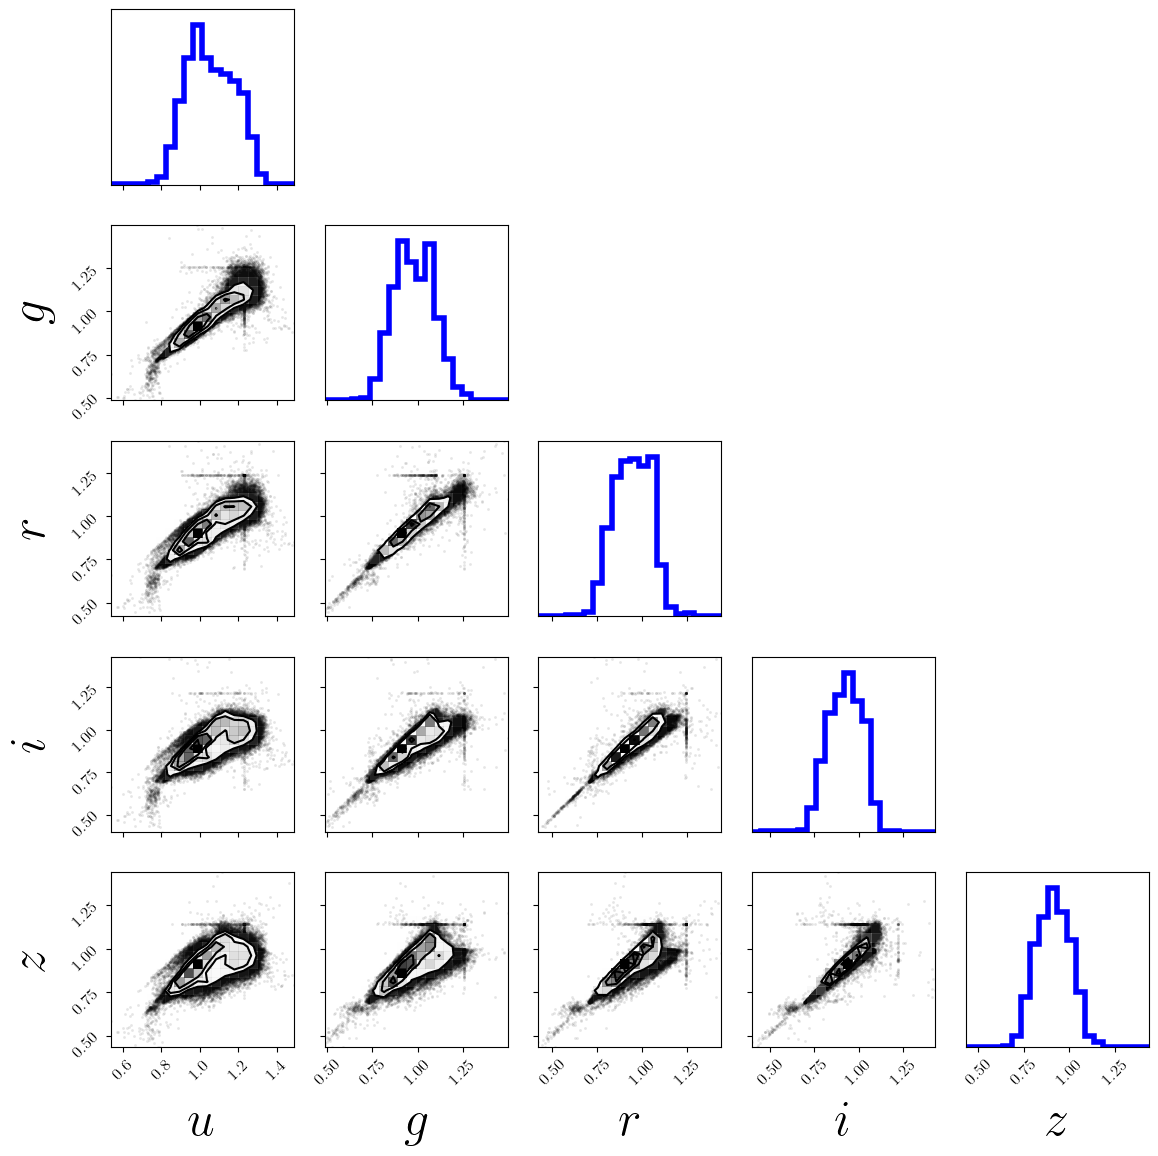

In [29]:
n_train = 150000
n_test  = 100000
n_valid =  len(data) - n_train - n_test

print("number of images for training:   %10d" % n_train)
print("number of images for testing:    %10d" % n_test)
print("number of images for validation: %10d" % n_valid)

# split and convert to tensors

train_x, X = torch.Tensor(data[:n_train]),  data[n_train:]
test_x, valid_x = torch.Tensor(X[:n_test]), torch.Tensor(X[n_test:])

plot_colors(test_x.detach().numpy())

## Training Utilities 

In [7]:
def get_random_batch(x, batch_size):
    indices = torch.randint(0, len(x)-1, size=(batch_size,))
    return x[indices]

In [8]:
def train(model, optimizer, getbatch, loss_fn, train_x, batch_size):
    
    model.train()

    # get a batch of training data
    x = getbatch(train_x, batch_size)
    
    # compute model
    pred_x = model(x)

    # compute loss functions, given the model outputs and the targets
    loss = loss_fn(pred_x, x)
    
    optimizer.zero_grad()  # clear previous gradients
    
    loss.backward()        # compute gradients
    
    optimizer.step()       # move one step
        
def validate(model, loss_fn, train_x, valid_x):
    
    n_valid = len(valid_x)
    
    model.eval()
    
    with torch.no_grad():  # no need to compute gradients wrt. to x, t

        # compute model
        pred_x = model(train_x[:n_valid])
        loss_t = loss_fn(pred_x, train_x[:n_valid]).data.cpu()

        pred_x = model(valid_x)
        loss_v = loss_fn(pred_x, valid_x).data.cpu()

    return loss_t, loss_v
               
def trainModel(model, optimizer, getbatch, averageloss, modelfile,
               train_x, valid_x, 
               n_iterations, batch_size, 
               xx=[], yy_t=[], yy_v=[], step=100):

    min_loss_v = 1e30
    print('%10s\t%10s\t%10s' % ('iteration', 'training', 'validation'))
    
    for ii in range(n_iterations):
        
        train(model, optimizer, getbatch, averageloss, train_x, batch_size)

        if ii % step == 0:
            
            loss_t, loss_v = validate(model, averageloss, train_x, valid_x)
            
            print("\r%10d\t%10.6f\t%10.6f" % (ii, loss_t, loss_v), end='')

            if len(xx) < 1:
                xx.append(0)
            else:
                xx.append(xx[-1]+step)
            yy_t.append(loss_t)
            yy_v.append(loss_v)
            
        if loss_v < min_loss_v:
            min_loss_v = loss_v
            torch.save(model.state_dict(), modelfile)
            
    print()
    return xx, yy_t, yy_v

In [9]:
def plot(x, y_t, y_v):
    # create an empty figure
    fig = plt.figure(figsize=(5, 4))
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title('Training and Validation Loss', fontsize=16)

    # axis limits
    ax.set_xlim((x[0], x[-1]))
    ax.set_xlabel('Iterations', fontsize=14)
    
    ax.set_ylabel('loss', fontsize=14)
    ax.set_yscale('log')
    
    ax.plot(x, y_t, 'b', label='Training')
    ax.plot(x, y_v, 'r', label='Validation')

    ax.grid(True, which="both", linestyle='-')

    ax.legend(loc='upper right')
    
    fig.tight_layout()
    plt.savefig('loss.png')
    plt.show()

## Load Model and Train

In [39]:
import AE
importlib.reload(AE)

model = AE.model.to(DEVICE)

print(model)

print('number of parameters:', AE.number_of_parameters(model))

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=5, out_features=40, bias=True)
    (1): SiLU()
    (2): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=40, out_features=40, bias=True)
    (4): SiLU()
    (5): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
    (6): Linear(in_features=40, out_features=40, bias=True)
    (7): SiLU()
    (8): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
    (9): Linear(in_features=40, out_features=40, bias=True)
    (10): SiLU()
    (11): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
    (12): Linear(in_features=40, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=40, bias=True)
    (1): SiLU()
    (2): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=40, out_features=40, bias=True)
    (4): SiLU()
    (5): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
    (6): Linear(in_features=40, out_features=

In [40]:
xx   = []  # iteration numbers
yy_t = []  # prediction accuracy using training data
yy_v = []  # prediction accuracy using validation data

 iteration	  training	validation
     99900	  0.000079	  0.000128

done!


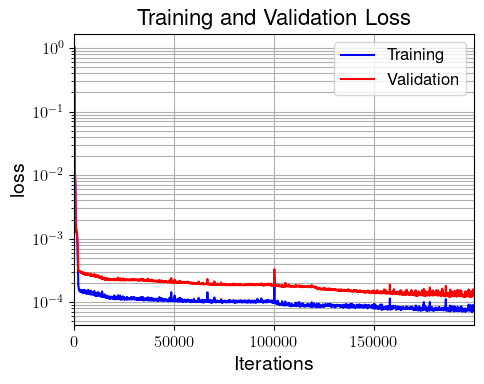

In [49]:
n_iter  = 100000    # number of iterations
n_batch =    256    # number of images/training batch
step    =    100
learning_rate = 1.0e-4

avloss = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

xx, yy_t, yy_v = trainModel(model, optimizer, get_random_batch, avloss, 
                            MODELFILE,
                            train_x, valid_x, 
                            n_iter,  n_batch, 
                            xx, yy_t, yy_v, 
                            step=step)

print("\ndone!")
plot(xx, yy_t, yy_v)

## Apply model to test data

In [50]:
def normalize_latent_space(z):
    # normalize latent space
    z1, z2 = z.transpose(0, 1)

    norm1 = nn.LayerNorm(z1.shape)
    z1 = norm1(z1).detach().numpy()

    norm2 = nn.LayerNorm(z2.shape)
    z2 = norm2(z2).detach().numpy()
    return z1, z2

In [59]:
def plot_latent(z1, z2, 
                xmin=-3.0, xmax=3.0, ymin=-3.0, ymax=3.0,
                filename='latent_space.png'):
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title('Latent Space', fontsize=16)

    # axis limits
    ax.set_xlim((xmin, xmax))
    ax.set_xlabel('$z_1$', fontsize=14)

    ax.set_ylim((ymin, ymax))
    ax.set_ylabel('$z_2$', fontsize=14)

    # plot data in latent space
    ax.scatter(z1, z2, color='blue', s=0.005)
        
    # histogram latent space 
    p, x, y = np.histogram2d(z1, z2, 
                             bins=(30, 30), 
                             range=((xmin, xmax), (ymin, ymax)))
    # Note: must transpose the p 2D array
    p = p.T / p.max()
    
    # compute bin centers
    x = (x[:-1] + x[1:])/2
    y = (y[:-1] + y[1:])/2
    
    # construct a meshgrid, that is, arrays x and y such that (x[i], y[i])
    # are the coordinates of the bin centers.
    x, y = np.meshgrid(x, y)

    mylevels = [0.01, 0.04, 0.08, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 0.9]
    cs = plt.contour(x, y, p, cmap='rainbow_r', levels=mylevels)

    ax.grid()
    
    fig.tight_layout()
    
    plt.savefig(filename)
    
    plt.show()

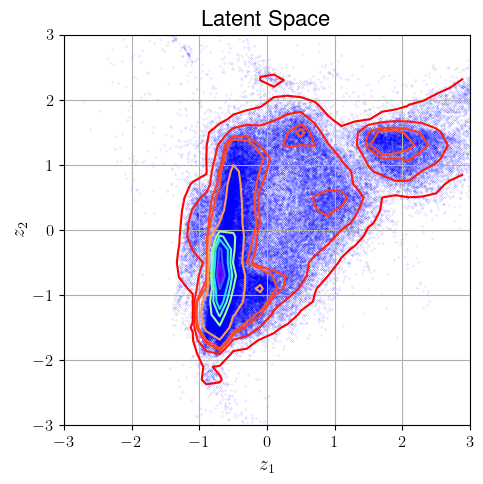

In [60]:
model.load_state_dict(torch.load(MODELFILE))

model.encoder.eval()

z = model.encoder(test_x)

z1, z2 = normalize_latent_space(z)

plot_latent(z1, z2)